<a href="https://colab.research.google.com/github/Baisal89/DS-Unit-2-Kaggle-Challenge/blob/master/assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Try other [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```



In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
X = train


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In [0]:
X.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [0]:
#train,test,val
train, val = train_test_split(X, train_size=0.80, test_size=0.20, stratify=train['status_group'])
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
#train['functional'] = (train['status_group']=='functional').astype(int)

In [0]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
38605,22421,0.0,2013-01-07,Tuwasa,0,TUWASA,32.806796,-5.023920,Kwa Mama Sonda,0,Lake Tanganyika,Kanisani,Tabora,14,6,Tabora Urban,Kanyenye,0,False,GeoData Consultants Ltd,Other,Mradi wa maji wa kanyenye,True,0,other,other,other,other,other,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
48740,26698,0.0,2013-02-04,Government Of Tanzania,1066,MUWASA,31.062228,-6.354025,Kwa Kabano,0,Lake Rukwa,Msasani,Rukwa,15,1,Mpanda,Kashaulili,2000,True,GeoData Consultants Ltd,Water authority,NaN,True,1996,nira/tanira,nira/tanira,handpump,water authority,commercial,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
7452,21414,0.0,2011-03-11,Kizenga,-23,Kizenga,38.851370,-5.783324,Kwa Kizenga,0,Pangani,Mkwaja,Tanga,4,5,Pangani,Mkwaja,60,False,GeoData Consultants Ltd,Private operator,NaN,False,2000,other,other,other,private operator,commercial,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,other,other,non functional
43999,56814,20.0,2013-06-03,Happy Watoto Foundation,1155,Happy watoto foundation,36.886703,-3.370135,Naftani,0,Pangani,Sokoni,Arusha,2,7,Meru,Maji ya Chai,120,True,GeoData Consultants Ltd,VWC,Imbaseny pumping wate supply,True,2006,ksb,submersible,submersible,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,functional needs repair
28027,59639,0.0,2011-07-17,Government Of Tanzania,0,DWE,33.260488,-2.557710,Kwa Lukas,0,Lake Victoria,Mbuga B,Mwanza,19,2,Magu,Kitongo Sima,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


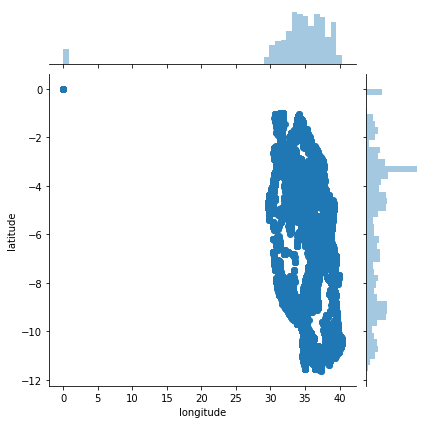

In [0]:
sns.jointplot(x='longitude', y='latitude', data=X);

In [0]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,47520.000000,47520.000000,47520.000000,47520.000000,4.752000e+04,47520.000000,47520.000000,47520.000000,47520.000000,47520.000000
mean,37098.496864,322.819820,668.454209,34.055961,-5.706131e+00,0.505177,15.295833,5.613405,179.524747,1300.331776
std,21455.855769,3198.541539,693.807338,6.609085,2.948442e+00,13.469472,17.565934,9.619908,473.617170,951.775330
min,1.000000,0.000000,-90.000000,0.000000,-1.164838e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18508.750000,0.000000,0.000000,33.082556,-8.534228e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37032.000000,0.000000,368.500000,34.900738,-5.025512e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55633.250000,20.000000,1320.000000,37.175828,-3.327877e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [0]:
train['construction_year'].mean()


1300.3317760942762

In [0]:
val['construction_year'].mean()

1301.9352693602693

In [0]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    #replacing with zeros
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace them with the column mean.
    cols_with_zeros = ['construction_year', 'longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())

        
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract year from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
   
    # for categoricals with missing values, fill with the category 'MISSING'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

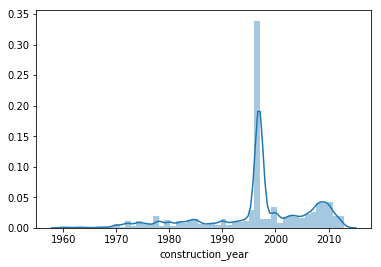

In [0]:
sns.distplot(train['construction_year'])

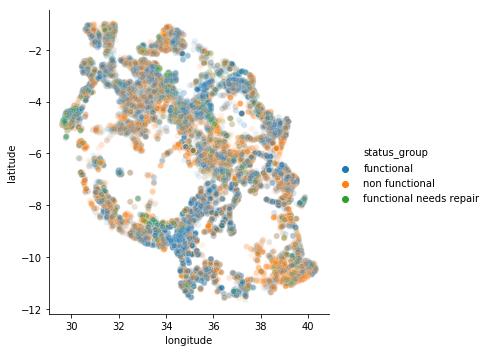

In [0]:
sns.relplot(x='longitude', y='latitude', hue='status_group', 
            data=train, alpha=0.1);

In [0]:
#select features

In [0]:
#our target will be the satus of the group
target = 'status_group'

In [0]:
#pull out the dataframe except the target and id
train_features = train.drop(columns=[target, 'id'])

In [0]:
train_features.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,year_recorded
38605,0.0,2013-01-07,Tuwasa,0,TUWASA,32.806796,-5.023920,Kwa Mama Sonda,0,Lake Tanganyika,Kanisani,Tabora,14,6,Tabora Urban,Kanyenye,0,False,GeoData Consultants Ltd,Other,Mradi wa maji wa kanyenye,True,1996.890059,other,other,other,other,other,pay per bucket,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2013
48740,0.0,2013-02-04,Government Of Tanzania,1066,MUWASA,31.062228,-6.354025,Kwa Kabano,0,Lake Rukwa,Msasani,Rukwa,15,1,Mpanda,Kashaulili,2000,True,GeoData Consultants Ltd,Water authority,MISSING,True,1996.000000,nira/tanira,nira/tanira,handpump,water authority,commercial,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,2013
7452,0.0,2011-03-11,Kizenga,-23,Kizenga,38.851370,-5.783324,Kwa Kizenga,0,Pangani,Mkwaja,Tanga,4,5,Pangani,Mkwaja,60,False,GeoData Consultants Ltd,Private operator,MISSING,False,2000.000000,other,other,other,private operator,commercial,never pay,never pay,soft,good,insufficient,shallow well,shallow well,groundwater,other,other,2011
43999,20.0,2013-06-03,Happy Watoto Foundation,1155,Happy watoto foundation,36.886703,-3.370135,Naftani,0,Pangani,Sokoni,Arusha,2,7,Meru,Maji ya Chai,120,True,GeoData Consultants Ltd,VWC,Imbaseny pumping wate supply,True,2006.000000,ksb,submersible,submersible,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,2013
28027,0.0,2011-07-17,Government Of Tanzania,0,DWE,33.260488,-2.557710,Kwa Lukas,0,Lake Victoria,Mbuga B,Mwanza,19,2,Magu,Kitongo Sima,0,True,GeoData Consultants Ltd,VWC,MISSING,True,1996.890059,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,salty,salty,enough,shallow well,shallow well,groundwater,hand pump,hand pump,2011


In [0]:
#listing numerics
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

In [0]:
numeric_features

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'year_recorded']

In [0]:
#cardinality of the nonumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()


In [0]:
cardinality

date_recorded              350
funder                    1697
installer                 1917
wpt_name                 30642
basin                        9
subvillage               17167
region                      21
lga                        124
ward                      2078
public_meeting               3
recorded_by                  1
scheme_management           12
scheme_name               2538
permit                       3
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
dtype: int64

In [0]:
#looking at the list of all categorical features with cardinality <=50

categorical_features = cardinality[cardinality <= 50].index.tolist()

In [0]:
categorical_features

['basin',
 'region',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [0]:
# put together lists
features = numeric_features + categorical_features

In [0]:
features

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'year_recorded',
 'basin',
 'region',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]


encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)


model = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

Validation Accuracy 0.7244107744107744
